In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision 
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os

plt.ion()

In [3]:
data_transforms = {
    'train':transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'val':transforms.Compose([
        transforms.Scale(256),
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
}

data_dir = 'hymenoptera_data'
dsets = {x:datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train','val']}
data_loaders = {x:torch.utils.data.DataLoader(dsets[x], batch_size = 4,
                                             shuffle = True, num_workers = 4)
               for x in ['train', 'val']}
dset_sizes = {x : len(dsets[x]) for x in ['train','val']}
print('size of training:{} \n'.format(dset_sizes['train']) + 'size of validation:{} \n'.format(dset_sizes['val']))
dset_classes = dsets['train'].classes
print('classes in training dataset: ',dset_classes)
use_gpu = torch.cuda.is_available()
print(use_gpu)

size of training:244 
size of validation:153 

classes in training dataset:  ['ants', 'bees']
False



 1
 0
 0
 1
[torch.LongTensor of size 4]



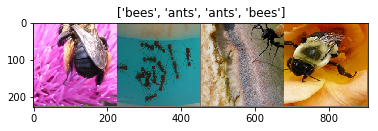

In [4]:
def imshow(inp, title = None):
    inp = inp.numpy().transpose((1,2,0)) # when loading by using ImageLoader, the image has been
    # transformed into tensor form, it is needed to reverse this process to display the image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

    
inputs, classes = next(iter(data_loaders['train']))
# inputs is the input image and the output is the corresponding labels
print(classes)

out = torchvision.utils.make_grid(inputs)

imshow(out, title = [dset_classes[x] for x in classes])

In [77]:
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs = 25):
    since = time.time()
    
    best_model = model
    
    best_acc = 0
     
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train','val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train(True) # set model to trianing model
            else:
                model.train(False)
                
            running_loss = 0.0
            
            running_corrects = 0
            
            for data in data_loaders[phase]:
                inputs, labels = data
                # get the input
                
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), \
                    Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                    
                optimizer.zero_grad()
                
                outputs = model(inputs)
                #print('ooo', outputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects / dset_sizes[phase]
            
            print('{} Loss:{:.4f} Acc:{:.4f}'.format(
            phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)
        print()
        
    time_elapsed = time.time() - since
        
    print('Training complete in {:.0f} m {:.0f} s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:.4f}'.format(best_acc))
        
    return best_model

In [73]:
def exp_lr_scheduler(optimizer, epoch, init_lr = 0.001, lr_decay_epoch = 7):
    lr = init_lr * (0.1 ** (epoch // lr_decay_epoch))
    
    if epoch % lr_decay_epoch == 0:
        print('LR is set to {:.4f}'.format(lr))
        
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

In [82]:
def visualize_model(model, num_images = 8):
    images_so_far = 0
    fig = plt.figure()
    
    for i, data in enumerate(data_loaders['val']):
        inputs, labels = data
        
        if use_gpu:
            inputs, lables = Variable(inputs.cuda()), Variable(lables.cuda())
        else:
            inputs, lables = Variable(inputs), Variable(labels)
        
        outputs = model(inputs)
        print(labels)
        _,preds = torch.max(outputs.data, 1)
        
        print(inputs.size())
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images // 2, images_so_far)
            ax.axis('off')
            ax.set_title('pre: {}'.format(dset_classes[labels[j]]))
            imshow(inputs.cpu().data[j])
            
            if images_so_far == num_images:
                return

In [75]:
model_ft = models.resnet18(pretrained = True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.001, momentum = 0.9)

In [76]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = 25)

Epoch 0/24
----------
LR is set to 0.0010
train Loss:0.1609 Acc:0.6475
val Loss:0.0718 Acc:0.9020

Epoch 1/24
----------


Process Process-96:
Process Process-95:
Process Process-94:
Process Process-93:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/collin/anaconda/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/collin/anaconda/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/collin/anaconda/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/collin/anaconda/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/collin/anaconda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/collin/anaconda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/collin/anaconda/lib/python3.6/multiproces

KeyboardInterrupt: 


 1
 0
 1
 1
[torch.LongTensor of size 4]

torch.Size([4, 3, 224, 224])

 1
 1
 0
 0
[torch.LongTensor of size 4]

torch.Size([4, 3, 224, 224])


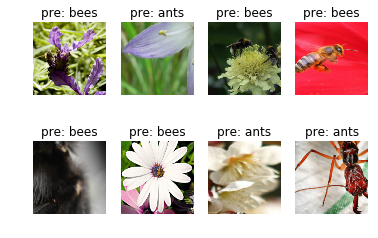

In [83]:
visualize_model(model_ft)